<a href="https://colab.research.google.com/github/fenix24dev/DataScience/blob/main/Entregas/ProyectoFinal_2Parte_Enrico_Lopez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

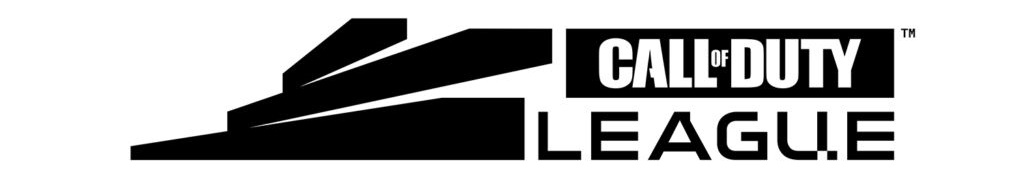

#Data StoryTelling

Al principio del ptoyecto solo estaba interesado en obtener las metricas de cada jugador para poder observar el desempeño de los nombres mas escuchados en los torneos, pero a medida que fui observando el dataset pude divisar una cierta tendencia o comportamiento que se repetia con el paso de los años entre los jugadores y los equipos auspiciantes, preguntandome asi si este comportamiento era acertado por ambas partes dado su desempeño durante las distintas temporadas.


Fue entonces cuando decidí empezar a analizar en mayor profundidad a los equipos y comprobar si su estructura de juego, basado en el rollplay de sus integrantes de manera individual, fue siempre la mejor o la más acertada para mantener el renombre del mismo y el dinero de los auspiciantes.

Dicho esto, se presenta el siguiente enlace con la presentación del proyecto:  https://docs.google.com/presentation/d/1iZCZhSNMhtriJRNJzBk7kLpDcctucRiyoy7h_i7kbNw/edit?usp=sharing

#Importe de librerías y dataset origen

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import urllib.request

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

Comenzamos con la importación de los datos directamente desde la api de Kaggle asi se optimiza el proceso de descarga del dataset.

In [ ]:
!pip install -q kaggle

!mkdir ~/.kaggle

In [ ]:
url =  ' https://drive.google.com/uc?export=download&id=1tfIEqG43pPeXGS0dS6jKwxRj9JrAddX1'
ruta_archivo = '/root/.kaggle/kaggle.json'

urllib.request.urlretrieve(url, ruta_archivo)

('/root/.kaggle/kaggle.json', <http.client.HTTPMessage at 0x7fc2914479a0>)

In [ ]:
!kaggle datasets download -d parvmodi/call-of-duty-world-league-championship

  0% 0.00/842k [00:00<?, ?B/s]
100% 842k/842k [00:00<00:00, 91.1MB/s]


In [ ]:
!unzip call-of-duty-world-league-championship

Archive:  call-of-duty-world-league-championship.zip
  inflating: Cod_cwl_data.csv        


In [ ]:
 url = "/content/Cod_cwl_data.csv"
 dfOriginal = pd.read_csv(url)
 dfOriginal.head()

<ipython-input-7-595b30c15ddd>:2: DtypeWarning: Columns (1,32,34,35,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  dfOriginal = pd.read_csv(url)


,Unnamed: 0,match id,series id,end time,duration (s),mode,map,team,player,win?,...,ctf returns,ctf pickups,ctf defends,ctf kill carriers,ctf flag carry time (s),scorestreaks earned,scorestreaks used,scorestreaks deployed,scorestreaks kills,scorestreaks assists
0,0,missing-pro-w1-1-map-1,pro-w1-1,2019-02-04 18:22:38 UTC,446,Hardpoint,Arsenal,Reciprocity,Denz,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,missing-pro-w1-1-map-1,pro-w1-1,2019-02-04 18:22:38 UTC,446,Hardpoint,Arsenal,Reciprocity,Seany,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,missing-pro-w1-1-map-1,pro-w1-1,2019-02-04 18:22:38 UTC,446,Hardpoint,Arsenal,Reciprocity,Tommey,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,missing-pro-w1-1-map-1,pro-w1-1,2019-02-04 18:22:38 UTC,446,Hardpoint,Arsenal,Reciprocity,Wuskin,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,missing-pro-w1-1-map-1,pro-w1-1,2019-02-04 18:22:38 UTC,446,Hardpoint,Arsenal,Reciprocity,Zed,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##El dataset original no será modificado para el siguiente proyecto, en vez de eso crearemos una réplica del mismo y trabajaremos esos datos

#Contexto del proyecto e hipótesis de interés

Junto a un sistema de torneos claramente viene acompañado un ranking y un esquema de estadísticas para cada uno de los jugadores. Datos como métricas de objetivo, asesinatos o muertes son solo algunos de los innumerables valores que se pueden obtener con ver una de estas partidas.

##Que vemos...

Con el pasar de los años, hemos visto que la mayoria de los jugadores que han entrado en racha para un equipo de esport ha renovado contrato con los mismos.

El objetivo del presente notebook es realizar un pequeño estudio sobre los jugadores y las decisiones de los equipos presentes en la CDL (Call of Duty League)

 Mediante el mismo se tratará de dar respuesta a preguntas como:

*   ¿Qué tan acertada podemos decir que ha sido esta evaluación de rendimiento?
*   ¿Qué tan eficiente es un jugador durante el torneo?
*   Los datos presentados, ¿realmente son significativos para lograr la victoria en cada partida?
*   ¿Cuáles equipos fueron los más persistentes a lo largo de su carrera?





#Procesamiento y análisis de datos

In [ ]:
#Creacion de Replica 1
dfCoD = dfOriginal

Primero observemos cuantos jugadores ha presentado un team entre 2017 - 19, teniendo en cuenta que solo se pueden registrar 4 jugadores y 1 suplente, podemos observar simplemente con las cifras cuales son los que estuvieron presentes en más torneos.



In [ ]:
CoDTeam= dfCoD['team'].value_counts()
jugadores_team= dfCoD['team'].value_counts().reset_index()
jugadores_team.rename(columns={'index':'Team'}, inplace=True)
jugadores_team

,Team,team
0,eUnited,905
1,OpTic Gaming,850
2,100 Thieves,840
3,Luminosity,810
4,Enigma6,810
5,Team Envy,770
6,Reciprocity,765
7,Heretics,745
8,Evil Geniuses,725
9,Gen.G,720




---



Habiendo respondido ya una de las incertidumbres del notebook, pasamos a realizar una tabla más pequeña sacando los equipos que tienen menos datos para omitirlos en el gráfico.

In [ ]:
index_df=dfCoD.set_index("team")
short_df=index_df.drop(["Celtic FC","Vanity","Carnage Gaming","ExcelerateGG","Aspire eSports","Fury Gaming","Hybrid Gaming","LGND Status GG","Sage eSports","TrainHard","Animosity","Fuego Gaming","RBL eSports","Mazer Gaming"])
short_df=short_df.reset_index()

Con este gráfico podemos ver más detalles como la media de kd, el máximo y el mínimo y en donde se encuentra en nivel la mayoría de jugadores, respecto a su equipo.

In [ ]:
fig = px.box(short_df,x="player", y="k/d", color="team")
fig.update_layout(title="Relacion de K/D por jugador y equipo", xaxis_title="Player",yaxis_title="K/D", legend_title="Team")
fig.show()

Una vez hecho el gráfico, podemos observar lo que planteamos antes, la media de relación entre los asesinatos y asistencias de cada jugador de en un equipo se encuentran entre los 2 y 3, con casos muy extremos en el cual los **slayers** pueden llegar a relaciones que superan los 8 en sus mejores temporadas.



---



¿Cuantas posibilidades de morir tiene un jugador durante la partida? Este gráfico es bastante sencillo, pero dejo una tabla para que se pueda observar como aumenta el riesgo a medida que uno se arriesga.

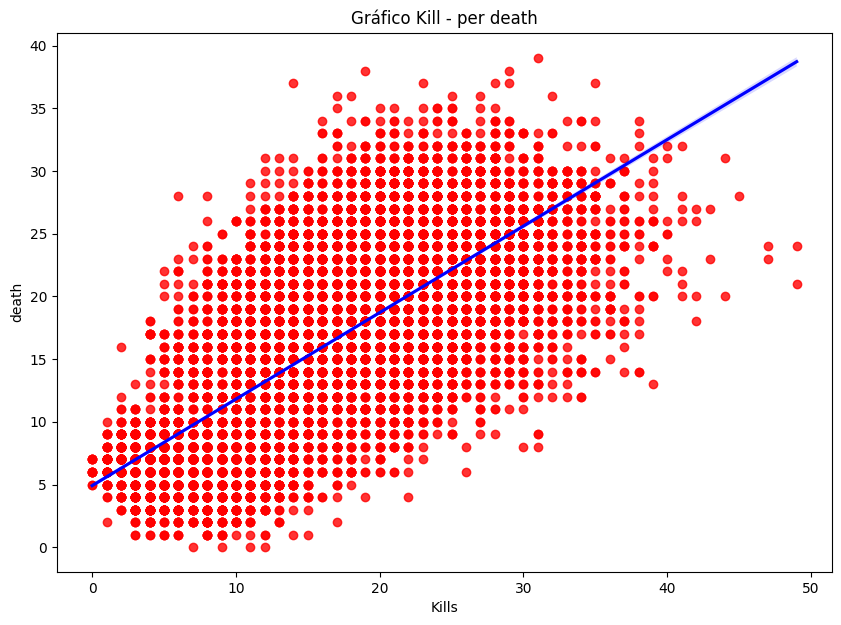

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
sns.regplot(x=dfCoD['kills'], y=dfCoD['deaths'], data=dfCoD, scatter_kws={"color": "red"}, line_kws={"color": "blue"})
plt.title("Gráfico Kill - per death")
plt.xlabel('Kills' )
plt.ylabel("death")
plt.show()

En este grafico realizaremos un análisis de los resultados del grafico anterior y podremos ver que por más que el grafico tenga una evaluación al alza en ambos casos, mientras más rusher es el player, más oportunidades tiene de morir dentro de la partida. Y como la media al saber esto se mantiene como máximo entre los 15/30 asesinatos por partida.



---



Habiendo obtenido las métricas de k/d del ejemplo anterior, procederemos a descubrir cuáles son las armas y accesorios más utilizados.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Arma mas usada')

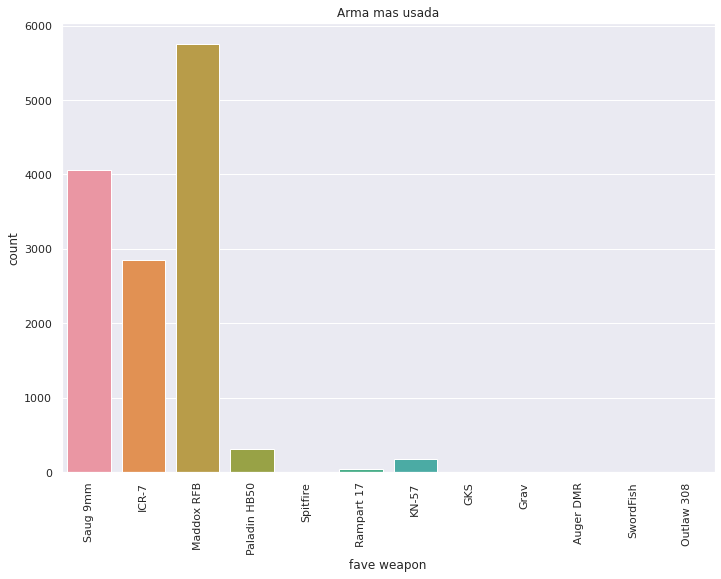

In [ ]:
sns.countplot(dfCoD['fave weapon'])
plt.xticks(rotation=90)
plt.title("Arma mas usada")

Podemos observar que, dentro de nuestras opciones de equipamiento, predominan los fusiles de asalto (ICR-7 y Maddox RFB) por sobre las demás categorías.



---



Habiendo respondido estas preguntas iniciales, afinemos un poco más el lápiz. ¿Cuáles son los mapas más recurrentes y que modos predominan en los torneos? ¿A qué debemos hacerle foco?

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Recurrencia de mapas')

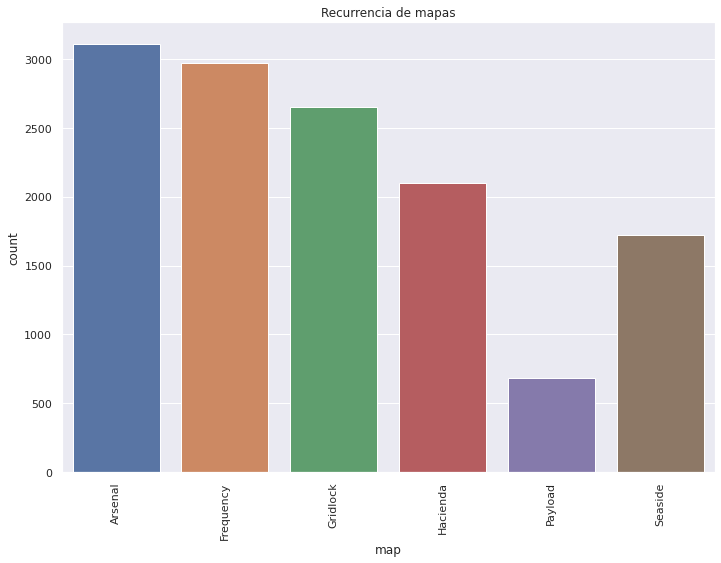

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(dfCoD['map'])
plt.xticks(rotation=90)
plt.title("Recurrencia de mapas")

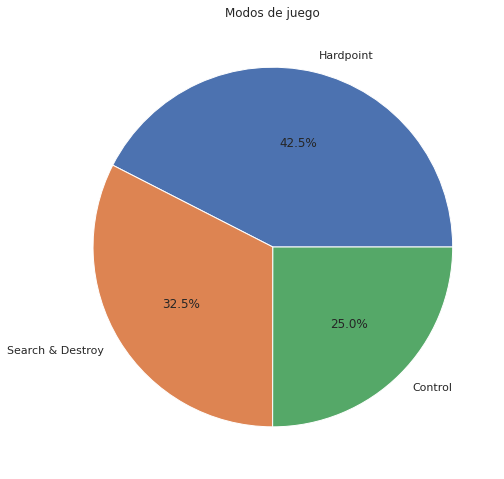

In [ ]:
plt.pie(dfCoD["mode"].value_counts(), labels=dfCoD["mode"].unique(),autopct='%1.1f%%')
plt.title("Modos de juego")
plt.show()



---



#Limpieza de datos y normalización

In [ ]:
# Convertir nulos NaN a 0
dfCoD = dfCoD.fillna(0)

In [ ]:
# Variables categóricas a numéricas
le = LabelEncoder()
for col in dfCoD.columns:
    if dfCoD[col].dtype == 'object':
        dfCoD[col] = le.fit_transform(dfCoD[col].astype(str))

# Normalizar variables numéricas
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(dfCoD), columns=dfCoD.columns)

dfCoD.head()

,match id,series id,end time,duration (s),mode,map,team,player,win?,score,...,ctf returns,ctf pickups,ctf defends,ctf kill carriers,ctf flag carry time (s),scorestreaks earned,scorestreaks used,scorestreaks deployed,scorestreaks kills,scorestreaks assists
Column1,,,,,,,,,,,,,,,,,,,,,
0,1318,127,0,446,1,0,23,39,0,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1318,127,0,446,1,0,23,135,0,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1318,127,0,446,1,0,23,152,0,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1318,127,0,446,1,0,23,162,0,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1318,127,0,446,1,0,23,166,0,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#ML

Se divide el dataset y se elimina la variable objetivo de la copia dejando solo los datos que vamos a utilizar para predecir ese objetivo, en este caso es la condicion de victoria bajo el label de " win? "

In [ ]:
caracteristicas = dfCoD.drop(columns = ['win?'])
c_objetivo = dfCoD['win?']

Usamos la función de `split` para dividirlo en una proporción de 70/30 para que tenga bastantes datos para practicar.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(caracteristicas,c_objetivo,test_size=0.3, random_state=1)

Luego ejecutamos un modelo de `RandomForest` para poder predecir si la condición de victoria bajo la información brindada es acertada.

In [ ]:
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

preds = modelo.predict(X_test)
pred_treino = modelo.predict(X_train)

Observemos como le fue a nuestro modelo

In [ ]:
print("Predic"+" "+metrics.classification_report(y_test, preds))

print("Treino"+" "+metrics.classification_report(y_train, pred_treino))

Predic               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1949
           1       1.00      1.00      1.00      2020

    accuracy                           1.00      3969
   macro avg       1.00      1.00      1.00      3969
weighted avg       1.00      1.00      1.00      3969

Treino               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4666
           1       1.00      1.00      1.00      4595

    accuracy                           1.00      9261
   macro avg       1.00      1.00      1.00      9261
weighted avg       1.00      1.00      1.00      9261



F1- Score RandonForest Predic
0. El modelo maneja perfectamente la clase
1. El modelo maneja perfectamente la clase


###Por ultimo realizamos una matriz de confusion para poder observar mas claramente cuantos aciertos y errores ha tenido nuestro modelo de machine learning.

Text(0.5, 1.0, 'Victorias acertadas')

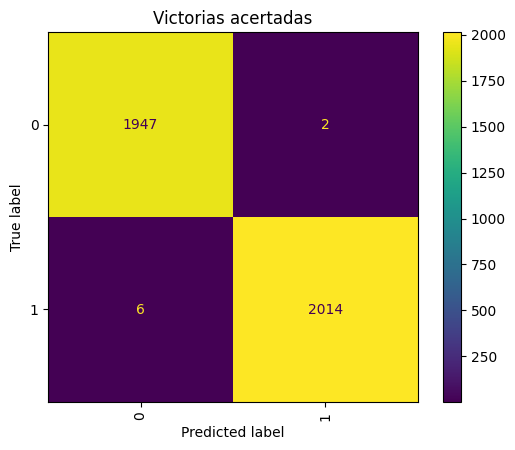

In [ ]:
ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, xticks_rotation="vertical")
plt.title("Victorias acertadas")

En esta matriz se puede observar que la muestra tiene muy poco error por lo tanto podemos decir que el modelo tiene mucha precisión o sufre de un caso de overfiting

#Conclusiones

Como hemos observado en el presente despliegue de información, podemos decir que:

1.   Los equipos con más constancia en los torneos siempre fueron los mismos hasta la fecha de la ejecución de este dataset.
2.   Rompemos el mito que menciona a los pro-players como jugadores inalcanzables con un KD exorbitante al momento de realizar una paridad de los mismos.
3.   Los datos proporcionados en este conjunto de datos se correlacionan entre si y no hay muchos errores presentes

**Aclaraciones:** Durante los primeros torneos habían valores que no eran objetivos de trabajo o presentaban un desinterés por parte de la liga, por lo cual tenemos una alta presencia de nulos al principio del trabajo


#Anexo

*   Rollplay = Posición y habilitades de cada jugador.
*   Team = Equipo.
*   Player = Jugador.
*   Slayer = Asesino (Rol de un jugador durante la partida).
*   Rusher = Nombre que se le otorga a un jugador con muy buenas habilidades en enfrentamientos rápidos y a corta distancia.
*   Pro-player = Jugador con excelentes métricas o de categoría competitiva.